In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import dill
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# import lightning as L
from collections import OrderedDict
# from electric_images_dataset import ElectricImagesDataset
# from EndToEndConvNN import EndToEndConvNN
# from EndToEndConvNN_PL import EndToEndConvNN_PL

import sys
sys.path.append("../../../electric_fish/ActiveZone/electrodynamic/objects")
sys.path.append("../../../electric_fish/ActiveZone/electrodynamic/helper_functions")
sys.path.append("../../../electric_fish/ActiveZone/electrodynamic/uniform_points_generation")
# sys.path.append("../../efish-physics-model/objects")
# sys.path.append("../../efish-physics-model/helper_functions")
# sys.path.append("../../efish-physics-model/uniform_points_generation")

In [3]:
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_13-characterization_dataset"
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_13-characterization_dataset_mockup"
dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
h5py_file = h5py.File(f"{data_dir_name}/responses.hdf5",'r')["responses"]

In [ ]:
worm_id = 297135
fish = dataset["fish"]["dataframe"]["objs"][0]
base_stim = dataset["electric_images"]["base"]["responses"][0]
modulation = (h5py_file[worm_id] / base_stim - 1) * 100
modulation[fish.get_receptors_locations()[:,0]< -0.11] = 0

In [ ]:
fish.visualize_scatter(intensity=modulation[:,0], show_normals=1, show_point_currents=5, marker_alpha=1)
print()

In [ ]:
img_data = modulation.reshape(30,20,2).transpose(1,0,2)[:,:,1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [ ]:
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

In [ ]:
img_data = dset[worm_id][0][1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [ ]:
dloader = DataLoader(dset, batch_size=32, shuffle=True)
batch = next(iter(dloader))
batch[0].shape, batch[1].shape

In [ ]:
input_noise_std = 0.25
activation = "relu"
layers_properties = OrderedDict(
    [
        (
            "conv1",
            dict(in_channels=1, out_channels=4, kernel_size=7, stride=1, max_pool=dict(kernel_size=3, stride=2)),
        ),
        (
            "conv2",
            dict(in_channels=4, out_channels=16, kernel_size=5, stride=1),
        ),
        (
            "conv3",
            dict(in_channels=16, out_channels=8, kernel_size=5, stride=1, max_pool=dict(kernel_size=3, stride=1)),
        ),
        # the fully connected layers can have dropout or flatten layers - some can miss the activation
        ("fc1", dict(dropout=0.5, flatten=True, in_features=160, out_features=80)),
        ("fc2", dict(dropout=0.5, in_features=80, out_features=40)),
        ("fc3", dict(in_features=40, out_features=6, activation=False)),
    ]
)

model_PL = EndToEndConvNN_PL(
    layers_properties=layers_properties, activation=activation, input_noise_std=input_noise_std, model_type="two_paths"
)

In [ ]:
out_model = model_PL.model.forward_print_dims(batch[0])

In [ ]:
filters = model_PL.model.sequence.conv1.conv.weight.detach().cpu().numpy()
vval = np.max(np.abs(filters))
f, ax = plt.subplots(filters.shape[1], filters.shape[0], figsize=(2*filters.shape[0], 2*filters.shape[1]))
for i in range(filters.shape[1]):
    for j in range(filters.shape[0]):
        cbar_ax = ax[i, j].imshow(filters[j, i], cmap="seismic", vmin=-vval, vmax=vval)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        sns.despine(ax=ax[i, j], left=True, bottom=True)
plt.show()

In [ ]:
train_dset, valid_dset, _ = torch.utils.data.random_split(dset, [0.05, 0.01, 0.94])
train_loader = DataLoader(train_dset, batch_size=27000, shuffle=True, drop_last=True, num_workers=12)
valid_loader = DataLoader(valid_dset, batch_size=27000, shuffle=False, drop_last=True, num_workers=12)

In [ ]:
trainer = L.Trainer(max_steps=1000)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

In [ ]:
# for batch_idx, batch in enumerate(train_loader):
#     print(batch[0].shape, end=" ")
#     if (batch_idx + 1) % 50 == 0:
#         print()

In [ ]:
# next(iter(train_loader))[0].shape

# Miscellaneous code

### Inspect R&C signal with filters and maxpooling

In [17]:
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_13-characterization_dataset"
dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
h5py_file = h5py.File(f"{data_dir_name}/responses.hdf5",'r')["responses"]
worm_properties = h5py.File(
    f"{data_dir_name}/torch_dataset_preprocess-worms_properties.hdf5", "r"
)["worms_properties"][:]

In [62]:
ids = np.where(
    (worm_properties[:, 0] == worm_properties[50000, 0])
    & (worm_properties[:, 1] == worm_properties[50, 1])
    & (worm_properties[:, 2] == worm_properties[50000, 2])
    & (worm_properties[:, 3] == worm_properties[500000, 3])
)[0]

In [69]:
worm_id = ids[11]
fish = dataset["fish"]["dataframe"]["objs"][0]
base_stim = dataset["electric_images"]["base"]["responses"][0]
modulation = (h5py_file[worm_id] / base_stim - 1) * 100
modulation = modulation.reshape(30, 20, 2).transpose(2, 1, 0)

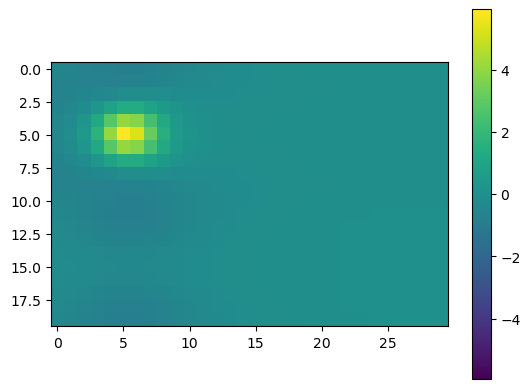

In [70]:
img_data = modulation[1]
vval = np.max(np.abs(img_data))
plt.imshow(img_data, cmap="viridis", vmin=-vval, vmax=vval)
plt.colorbar()
plt.show()

In [172]:
modulations = (h5py_file[ids] / base_stim - 1) * 100
modulations = torch.Tensor(modulations.reshape(-1, 30, 20, 2).transpose(0, 3, 2, 1))
processed = nn.functional.conv2d(modulations, torch.Tensor(np.ones([2,1,7,7]) / np.ones([2,1,7,7]).sum()), groups=2)
processed_m = torch.amax(-processed, (2,3))
processed_p = torch.amax(processed, (2,3))

processed_1 = processed[:,0].reshape(processed.shape[0], -1)
processed_1 = processed_1.abs().max(1).values * processed_1[torch.arange(processed.shape[0]), processed_1.abs().argmax(1)].sign()
processed_2 = processed[:,1].reshape(processed.shape[0], -1)
processed_2 = processed_2.abs().max(1).values * processed_2[torch.arange(processed.shape[0]), processed_2.abs().argmax(1)].sign()

# processed = processed.reshape(processed.shape[0], 2, -1)
# processed_signs = processed[torch.arange(processed.shape[0]), processed.abs().argmax(1)].sign()

In [176]:
processed.abs().argmax(0).shape

torch.Size([2, 14, 24])

In [183]:
temp = torch.randint(10,(3,5,2))
temp

tensor([[[2, 7],
         [4, 5],
         [5, 7],
         [7, 4],
         [6, 9]],

        [[1, 3],
         [7, 2],
         [6, 0],
         [7, 2],
         [3, 7]],

        [[8, 8],
         [5, 1],
         [2, 7],
         [2, 4],
         [4, 4]]])

In [192]:
temp.argmax(1, keepdim=True)

tensor([[[3, 4]],

        [[1, 4]],

        [[0, 0]]])

In [191]:
temp[temp.argmax(1, keepdim=True)]

IndexError: index 3 is out of bounds for dimension 0 with size 3

In [171]:
print(processed_p.shape, processed_m.shape)

torch.Size([900, 2]) torch.Size([900, 2])


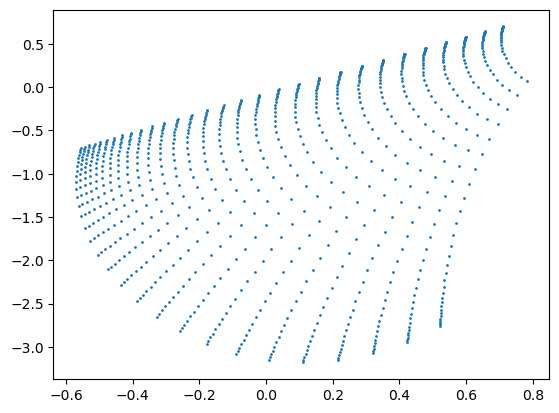

In [162]:
plt.scatter(processed_p, processed_m, s=1)
plt.show()

### Compare dataset parameters

In [ ]:
dataset_new = dill.load(open("../../efish-physics-model/data/params/data-2024_06_13-characterization_dataset.pkl", "rb"))
dataset_new

In [ ]:
dataset_old = dill.load(open("../../../electric_fish/ActiveZone/electrodynamic/data/params/data_230324_YES_manyObjects_NO_boundaries_NO_tail_ONE_conductivity_OnlyFEW_R_C_params_dict.pkl", "rb"))
dataset_old

In [ ]:
dataset_old = {
    "worm_resistances": np.array(
        [
            187.38174229,
            376.49358068,
            756.46332755,
            1519.91108295,
            3053.85550883,
            6135.90727341,
            12328.46739442,
            24770.76355992,
            49770.23564332,
            100000.0,
        ]
    ),
    "worm_capacitances": np.array(
        [
            1.87381742e-10,
            3.76493581e-10,
            7.56463328e-10,
            1.51991108e-09,
            3.05385551e-09,
            6.13590727e-09,
            1.23284674e-08,
            2.47707636e-08,
            4.97702356e-08,
            1.00000000e-07,
        ]
    ),
    "worm_radii": np.array(
        [
            0.0015,
            0.002,
            0.0025,
            0.003,
            0.0035,
            0.004,
            0.0045,
            0.005,
            0.0055,
            0.006,
            0.0065,
            0.007,
            0.0075,
            0.008,
            0.0085,
            0.009,
            0.0095,
            0.01,
            0.0105,
            0.011,
        ]
    ),
    "worm_position_xs": np.array(
        [
            0.015,
            0.01,
            0.005,
            0.0,
            -0.005,
            -0.01,
            -0.015,
            -0.02,
            -0.025,
            -0.03,
            -0.035,
            -0.04,
            -0.045,
            -0.05,
            -0.055,
            -0.06,
            -0.065,
            -0.07,
            -0.075,
            -0.08,
        ]
    ),
    "worm_position_ys": np.array(
        [
            0.018,
            0.0185,
            0.019,
            0.0195,
            0.02,
            0.0205,
            0.021,
            0.0215,
            0.022,
            0.0225,
            0.023,
            0.0235,
            0.024,
            0.0245,
            0.025,
            0.0255,
            0.026,
            0.0265,
            0.027,
            0.0275,
            0.028,
            0.0285,
            0.029,
            0.0295,
            0.03,
        ]
    ),
    "worm_position_zs": np.array(
        [
            -0.015,
            -0.0135,
            -0.012,
            -0.0105,
            -0.009,
            -0.0075,
            -0.006,
            -0.0045,
            -0.003,
            -0.0015,
            0.0,
            0.0015,
            0.003,
            0.0045,
            0.006,
            0.0075,
            0.009,
            0.0105,
            0.012,
            0.0135,
            0.015,
        ]
    ),
}

dataset_new = {
    "worm_resistances": np.array(
        [
            2000.0,
            2288.83859595,
            2619.39105916,
            2997.68167704,
            3430.60476039,
            3926.05029152,
            4493.04771843,
            5141.9305157,
            5884.52451101,
            6734.36340981,
            7706.93544576,
            8819.96565237,
            10093.73890005,
            11551.46958594,
            13219.72471412,
            15128.90807676,
            17313.81436033,
            19814.26327552,
            22675.82526766,
            25950.65203382,
            29698.42698254,
            33987.45295832,
            38895.89705452,
            44513.21520124,
            50941.78249122,
            58298.75895619,
            66718.22479746,
            76353.62398485,
            87380.56075858,
            100000.0,
        ]
    ),
    "worm_capacitances": np.array(
        [
            2.00000000e-10,
            2.28883860e-10,
            2.61939106e-10,
            2.99768168e-10,
            3.43060476e-10,
            3.92605029e-10,
            4.49304772e-10,
            5.14193052e-10,
            5.88452451e-10,
            6.73436341e-10,
            7.70693545e-10,
            8.81996565e-10,
            1.00937389e-09,
            1.15514696e-09,
            1.32197247e-09,
            1.51289081e-09,
            1.73138144e-09,
            1.98142633e-09,
            2.26758253e-09,
            2.59506520e-09,
            2.96984270e-09,
            3.39874530e-09,
            3.88958971e-09,
            4.45132152e-09,
            5.09417825e-09,
            5.82987590e-09,
            6.67182248e-09,
            7.63536240e-09,
            8.73805608e-09,
            1.00000000e-08,
        ]
    ),
    "worm_radii": np.array(
        [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075]
    ),
    "worm_position_xs": np.array(
        [
            0.02,
            0.0125,
            0.005,
            -0.0025,
            -0.01,
            -0.0175,
            -0.025,
            -0.0325,
            -0.04,
            -0.0475,
            -0.055,
            -0.0625,
            -0.07,
            -0.0775,
            -0.085,
            -0.0925,
        ]
    ),
    "worm_position_ys": np.array(
        [
            0.017,
            0.018,
            0.019,
            0.02,
            0.021,
            0.022,
            0.023,
            0.024,
            0.025,
            0.026,
            0.027,
            0.028,
            0.029,
            0.03,
            0.031,
            0.032,
            0.033,
            0.034,
            0.035,
            0.036,
            0.037,
            0.038,
            0.039,
        ]
    ),
    "worm_position_zs": np.array([-0.03, -0.024, -0.018, -0.012, -0.006, 0.0, 0.006, 0.012, 0.018, 0.024, 0.03]),
}

In [ ]:
for k in dataset_old:
    print(k.upper())
    print(dataset_old[k])
    print(dataset_new[k])
    print()